In [1]:
import os
import cv2 
from matplotlib import pyplot as plt
import numpy as np

In [68]:
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_DEFAULT)

def extract_sift_features(img):
    sift = cv2.SIFT_create()
    kp, features = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
    return kp, features

def match_sift_features(des1, des2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    return matches

def sift_match_images(img1, img2):
    kp1, des1 = extract_sift_features(img1)
    kp2, des2 = extract_sift_features(img2)
    matches = match_sift_features(des1, des2)
    return matches, kp1, kp2

def get_good_matches(matches):
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    return sorted(good, key = lambda x: x[0].distance)

def draw_matches(matches, img1, img2, kp1, kp2):
    m_img = cv2.drawMatchesKnn(
    img1, kp1,
    img2, kp2,
    matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(m_img)
    plt.axis("off")
    return None

def stack_A(kp1, kp2):
    A_0 = np.zeros((1,9))
    x = kp1.pt[0]
    y = kp1.pt[1]
    x_dash = kp2.pt[0]
    y_dash = kp2.pt[1]
    A_0 = np.array([x*x_dash, x*y_dash, x, y*x_dash, y*y_dash, y, x_dash, y_dash, 1])
    return A_0

def estimate_F(kps1, kps2):
    A = np.zeros((8,9))
    for i in range(8):
        A[i] = stack_A(kps1[i], kps2[i])
    U, S, Vt = np.linalg.svd(A, full_matrices=True)
    F = Vt[-1].reshape(3,3)
    u, s, vt = np.linalg.svd(F, full_matrices=True)
    sd = np.diag(s)
    sd[2,2] = 0
    F = np.dot(u, np.dot(sd, vt))
    return F

def get_keypoints(matches, kp1, kp2):
    img1_kp_list = []
    img2_kp_list = []
    for i in matches:
        qidx = i[0].queryIdx
        tidx = i[0].trainIdx
        kp1_xy = kp1[qidx]
        kp2_xy = kp2[tidx]
        img1_kp_list.append(kp1_xy)
        img2_kp_list.append(kp2_xy)
    return img1_kp_list, img2_kp_list
    
def normalize_points(pts):
    pts = np.array(pts)
    
def RANSAC_F(good_matches, kp1, kp2, steps=10, eps=0.1):
    F = None
    inliers = None
    max_inliners = None
    return F, inliers, max_inliers

# def estimate_E(k, F):
#     E = np.dot(np.dot(k.T, F), k)
#     U, S, Vt = np.linalg.svd(E)
#     S = np.diag((1,1,0))
#     E = np.dot(np.dot(U, S), Vt)
#     return E

# def get_camera_pose(E):
#     W = np.array([0, -1, 0, 1, 0, 0, 0, 0, 1]).reshape(3,3)
#     U, D, Vt = np.linalg.svd(E)
#     c1 = (U[:, 2], np.dot(np.dot(U, W), Vt))
#     c2 = (-U[:, 2], np.dot(np.dot(U, W), Vt))
#     c3 = (U[:, 2], np.dot(np.dot(U, W.T), Vt))
#     c4 = (-U[:, 2], np.dot(np.dot(U, W.T), Vt))
#     print(c1)
#     if np.linalg.det(c1[1]) < 0: c1 *= -1.0
#     if np.linalg.det(c2[1]) < 0: c2 *= -1.0
#     if np.linalg.det(c3[1]) < 0: c3 *= -1.0
#     if np.linalg.det(c4[1]) < 0: c4 *= -1.0
#     return c1, c2, c3, c4

def estimate_E(k, F):
    E = k.T @ F @ k
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
    if np.linalg.det(Vt) < 0:
        Vt[-1, :] *= -1
    S = np.diag([1,1,0])
    E = U @ S @ Vt
    return E

def get_camera_pose(E):
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
    if np.linalg.det(Vt) < 0:
        Vt[-1, :] *= -1
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    if np.linalg.det(R1) < 0:
        R1 *= -1
    if np.linalg.det(R2) < 0:
        R2 *= -1
    t = U[:,2]
    c1 = (t, R1)
    c2 = (-t, R1)
    c3 = (t, R2)
    c4 = (-t, R2)
    return c1, c2, c3, c4

# def point_triangulation(k,pt1,pt2,R1,C1,R2,C2):
#     points_3d = []
#     I = np.identity(3)
#     C1 = C1.reshape(3,1)
#     C2 = C2.reshape(3,1)
#     P1 = K @ np.hstack((R1, -R1 @ C1))
#     P2 = K @ np.hstack((R2, -R2 @ C2))
#     xy = np.hstack((pt1,np.ones((len(pt1),1))))
#     xy_cap = np.hstack((pt2,np.ones((len(pt1),1))))
#     p1,p2,p3 = P1
#     p1_cap, p2_cap,p3_cap = P2
#     for i in range(len(xy)):
#         A = []
#         x = xy[i][0]
#         y = xy[i][1]
#         x_cap = xy_cap[i][0]
#         y_cap = xy_cap[i][1] 
#         A.append((y*p3) - p2)
#         A.append((x*p3) - p1)
#         A.append((y_cap*p3_cap)- p2_cap)
#         A.append((x_cap*p3_cap) - p1_cap)
#         A = np.array(A).reshape(4,4)
#         _, _, v = np.linalg.svd(A)
#         x_ = v[-1,:]
#         x_ = x_/x_[-1]
#         points_3d.append(x_)
#     return np.array(points_3d)

def point_triangulation(k,pt1,pt2,R1,C1,R2,C2):
    points_3d = []
    C1 = C1.reshape(3,1)
    C2 = C2.reshape(3,1)
    P1 = k @ np.hstack((R1, -R1 @ C1))
    P2 = k @ np.hstack((R2, -R2 @ C2))
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    for i in range(len(pt1)):
        x,y = pt1[i]
        x2,y2 = pt2[i]
        A = np.array([
            x*P1[2]-P1[0],
            y*P1[2]-P1[1],
            x2*P2[2]-P2[0],
            y2*P2[2]-P2[1]
        ])
        _,_,Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X/X[-1]
        points_3d.append(X)
    return np.array(points_3d)

def linear_triangulation(R_Set, T_Set, pt1, pt2, k):
    R1 = np.eye(3)
    C1 = np.zeros(3)
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    best_points = None
    max_positive = -1
    best_index = -1
    for i in range(len(R_Set)):
        R2 = R_Set[i]
        C2 = T_Set[i]
        pts3d = point_triangulation(k, pt1, pt2, R1, C1, R2, C2)
        X = pts3d[:, 0:3].T
        Z1 = X[2]
        X2 = R2 @ (X - C2.reshape(3,1))
        Z2 = X2[2]
        positive = np.sum((Z1>0) & (Z2>0))
        if positive > max_positive:
            max_positive = positive
            best_points = pts3d
            best_index = i
    return best_points, best_index

# def linear_triangulation(R_Set,T_Set,pt1,pt2,k):
#     R1_ = np.identity(3)
#     T1_ = np.zeros((3,1))
#     points_3d_set = []
#     for i in range(len(R_Set)):
#         points3d = point_triangulation(k,pt1,pt2,R1_,T1_,R_Set[i],T_Set[i])
#         points_3d_set.append(points3d)
#     return points_3d_set

def convert_kp_to_numpy(kp):
    return kp.pt

def draw_triangulation(points_3d, R2=None, C2=None):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    pts = np.array(points_3d)
    X = pts[:,0]
    Y = pts[:,1]
    Z = pts[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, c='b', s=5)
    ax.scatter(0, 0, 0, c='r', s=100)
    if R2 is not None and C2 is not None:
        C2 = np.array(C2).reshape(3,)
        ax.scatter(C2[0], C2[1], C2[2], c='g', s=100)
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [69]:
BASE_DIR = "/home/deveshdatwani/sfm/P3Data/"
image_names = ["1.png", "2.png", "3.png", "4.png", "5.png"]
k =  np.array([531.122155322710, 0, 407.192550839899,
                0, 531.541737503901, 313.308715048366,
                0, 0, 1]).reshape((3,3))

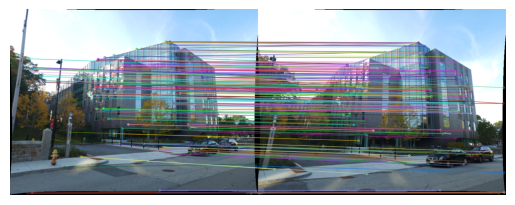

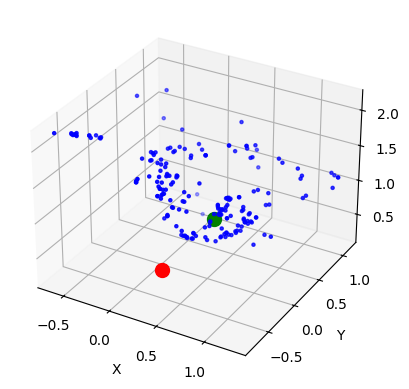

In [72]:
img = [cv2.cvtColor(cv2.imread(os.path.join(BASE_DIR, image_names[i])), cv2.COLOR_BGR2RGB) for i in range(5)] 
matches, kp1, kp2 = sift_match_images(img[0], img[1])
good_matches = get_good_matches(matches)[:200]
draw_matches(good_matches, img[0], img[1], kp1, kp2)
keypoints1, keypoints2 = get_keypoints(good_matches, kp1, kp2)
F = estimate_F(keypoints1[:8], keypoints2[:8])
E = estimate_E(K, F)
camera_pose = get_camera_pose(E)
R_SET = [i[1] for i in camera_pose]
T_SET = [i[0] for i in camera_pose]
d3_points, best_pose_idx = linear_triangulation(
    R_SET, T_SET,
    [convert_kp_to_numpy(i) for i in keypoints1],
    [convert_kp_to_numpy(j) for j in keypoints2],
    K
)
draw_triangulation(d3_points, R_SET[best_pose_idx], T_SET[best_pose_idx])

In [59]:
d3_points[2][1]

array([1.08876017, 0.14169519, 0.83127726, 1.        ])

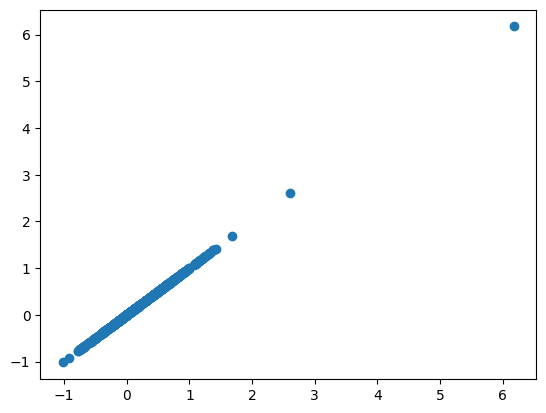

In [60]:
plt.scatter(d3_points[2][:,:2], d3_points[2][:,:2])

In [67]:
print(d3_points.shape)
print(np.isnan(d3_points).sum())
print(np.max(np.abs(d3_points)))

AttributeError: 'list' object has no attribute 'shape'